# 强化学习

## 环境配置

In [1]:
import numpy as np
import os
import sys

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures and animations
%matplotlib nbagg
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "D:/Python3Space/BookStudy/book4/chapter16/images/"
CHAPTER_ID = "rl"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

## OpenAI gym介绍

In [2]:
import gym

加载 MsPacman环境

In [3]:
env = gym.make('MsPacman-v0')

初始化环境

In [4]:
obs = env.reset()

返回红绿蓝三个通道的numpy

In [5]:
obs.shape

(210, 160, 3)

设置显示模型

In [6]:
img = env.render(mode="rgb_array")

绘图

<IPython.core.display.Javascript object>


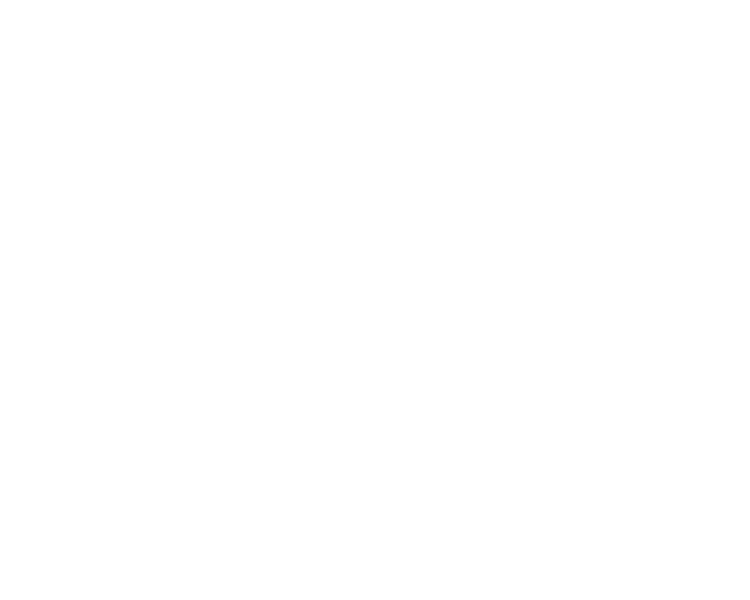

In [7]:
plt.figure(figsize=(5,4))
plt.imshow(img)
plt.axis("off")
# save_fig("MsPacman")
plt.show()

在这种环境中，渲染的图像与观察结果完全相同（但在许多环境中并非如此）

In [8]:
(img == obs).all()

True

创建一个函数来帮助绘制环境

In [9]:
def plot_environment(env, figsize=(5,4)):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    plt.show()

接下来如何与环境进行交互

In [10]:
env.action_space

Discrete(9)

离散（9）意味着可能的动作是整数0到8，它代表操纵杆的9个可能位置（0 =中心，1 =上，2 =右，3 =左，4 =下，5 =上右 ，6 =左上，7 =右下，8 =左下）。

接下来我们需要告诉环境要播放哪个动作，它将计算游戏的下一步。 让我们左转110步，然后左下40步：

In [11]:
env.reset()
for step in range(110):
    env.step(3) #left
for step in range(40):
    env.step(8) #lower-left

<IPython.core.display.Javascript object>


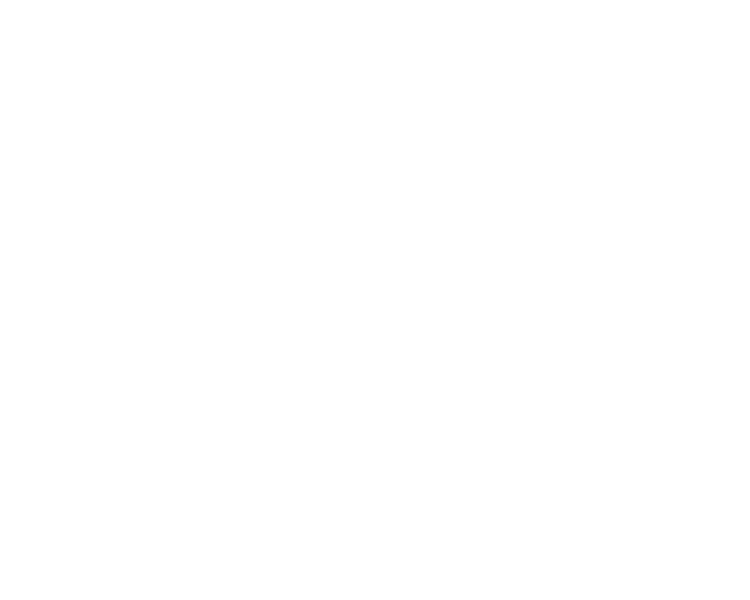

In [12]:
plot_environment(env)

step（）函数实际上返回了几个重要的对象：

In [13]:
obs, reward, done, info = env.step(0)

如前所述，观察结果告诉代理人环境是什么样的。 这是一张210x160的RGB图像：

In [14]:
obs.shape

(210, 160, 3)

环境还告诉代理商在最后一步获得了多少奖励：

In [15]:
reward

0.0

当游戏结束时，环境返回done = True：

In [16]:
done

False

最后，info是一个特定于环境的字典，可以提供有关环境内部状态的一些额外信息。 这对于调试非常有用，但是您的代理不应该使用此信息进行学习（这将是作弊）。

In [17]:
info

{'ale.lives': 3}

让我们玩一个完整的游戏（有3个生命），一次向后移动10个步骤，记录每个帧：

In [18]:
frames = []

n_max_steps = 1000
n_change_steps = 10

obs = env.reset()
for step in range(n_max_steps):
    img = env.render(mode="rgb_array")
    frames.append(img)
    if step % n_change_steps == 0:
        action = env.action_space.sample() # play randomly
    obs, reward, done, info = env.step(action)
    if done:
        break

现在展示动画

In [19]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    return animation.FuncAnimation(fig, update_scene, fargs=(frames, patch), frames=len(frames), repeat=repeat, interval=interval)

<IPython.core.display.Javascript object>


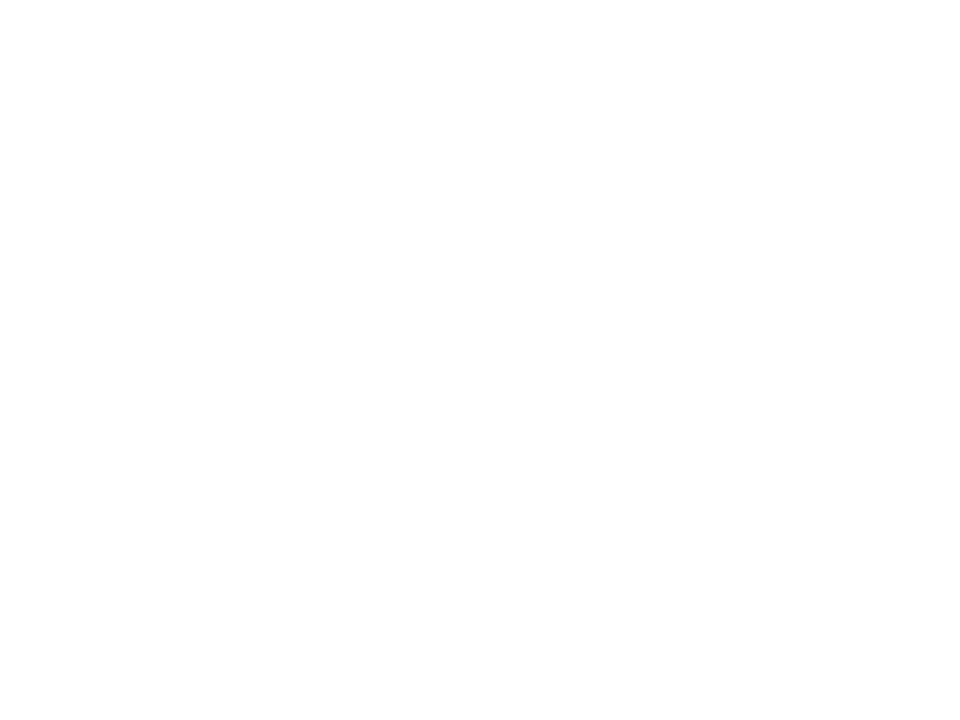

In [20]:
video = plot_animation(frames)
plt.show()

完成环境播放后，应关闭它以释放资源：

In [21]:
env.close()

为了编写我们的第一个学习代理，我们将使用更简单的环境：Cart-Pole。

## 一个简单的环境：Cart-Pole

Cart-Pole是一个非常简单的环境，由可以向左或向右移动的推车组成，并且杆垂直放置在其上方。 代理人必须向左或向右移动推车以使杆保持直立。

In [22]:
env = gym.make("CartPole-v0")

In [23]:
obs = env.reset()

In [24]:
obs

array([-0.01009272,  0.03295619,  0.02457111, -0.04640264])

观察是由4个浮点组成的1D NumPy阵列：它们代表推车的水平位置，速度，极点的角度（0 =垂直）和角速度。 让我们渲染环境......不幸的是，我们需要首先修复恼人的渲染问题。

## 修复渲染问题

某些环境（包括Cart-Pole）需要访问您的显示器，即使您指定了rgb_array模式，也会打开一个单独的窗口。 通常，您可以安全地忽略该窗口。 但是，如果Jupyter在无头服务器上运行（即没有屏幕），它将引发异常。 避免这种情况的一种方法是安装假X服务器，如Xvfb。 您可以使用xvfb-run命令启动Jupyter：

$ xvfb-run -s "-screen 0 1400x900x24" jupyter notebook

如果Jupyter在无头服务器上运行但你不想担心Xvfb，那么你可以使用以下渲染函数来实现Cart-Pole：

In [25]:
from PIL import Image, ImageDraw

try:
    from pyglet.gl import gl_info
    openai_cart_pole_rendering = True   # no problem, let's use OpenAI gym's rendering function
except Exception:
    openai_cart_pole_rendering = False  # probably no X server available, let's use our own rendering function

def render_cart_pole(env, obs):
    if openai_cart_pole_rendering:
        # use OpenAI gym's rendering function
        return env.render(mode="rgb_array")
    else:
        # rendering for the cart pole environment (in case OpenAI gym can't do it)
        img_w = 600
        img_h = 400
        cart_w = img_w // 12
        cart_h = img_h // 15
        pole_len = img_h // 3.5
        pole_w = img_w // 80 + 1
        x_width = 2
        max_ang = 0.2
        bg_col = (255, 255, 255)
        cart_col = 0x000000 # Blue Green Red
        pole_col = 0x669acc # Blue Green Red

        pos, vel, ang, ang_vel = obs
        img = Image.new('RGB', (img_w, img_h), bg_col)
        draw = ImageDraw.Draw(img)
        cart_x = pos * img_w // x_width + img_w // x_width
        cart_y = img_h * 95 // 100
        top_pole_x = cart_x + pole_len * np.sin(ang)
        top_pole_y = cart_y - cart_h // 2 - pole_len * np.cos(ang)
        draw.line((0, cart_y, img_w, cart_y), fill=0)
        draw.rectangle((cart_x - cart_w // 2, cart_y - cart_h // 2, cart_x + cart_w // 2, cart_y + cart_h // 2), fill=cart_col) # draw cart
        draw.line((cart_x, cart_y - cart_h // 2, top_pole_x, top_pole_y), fill=pole_col, width=pole_w) # draw pole
        return np.array(img)

def plot_cart_pole(env, obs):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    img = render_cart_pole(env, obs)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

<IPython.core.display.Javascript object>


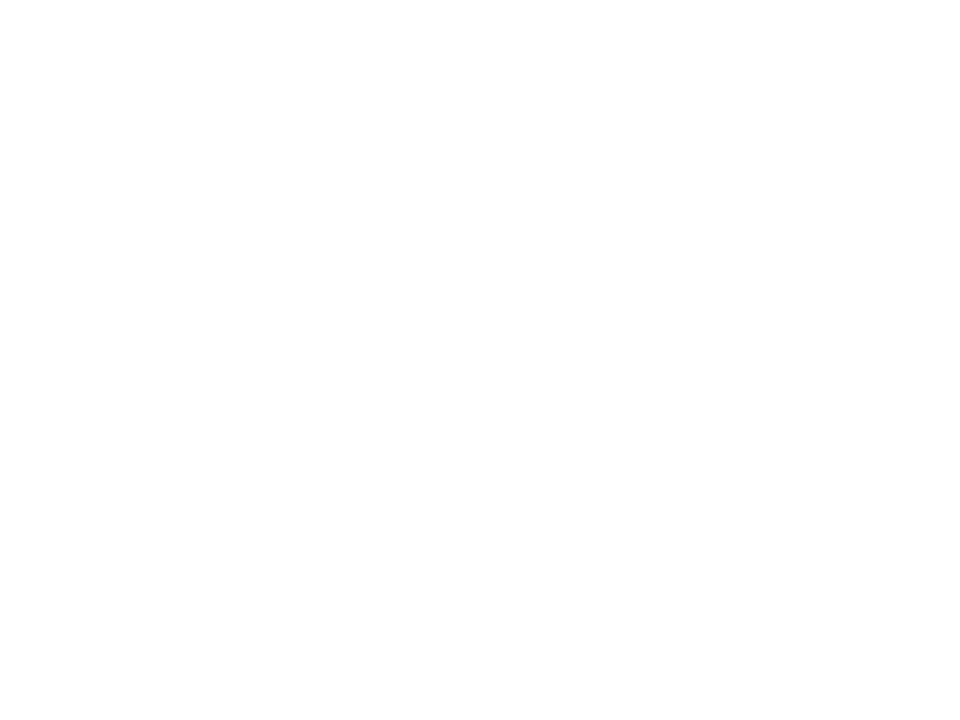

In [26]:
plot_cart_pole(env, obs)

In [27]:
env.action_space

Discrete(2)

是的，只有两个可能的动作：向左或向右加速。 让我们向左推车直到杆下降：

In [28]:
obs = env.reset()
while True:
    obs, reward, done, info = env.step(0)
    if done:
        break

<IPython.core.display.Javascript object>


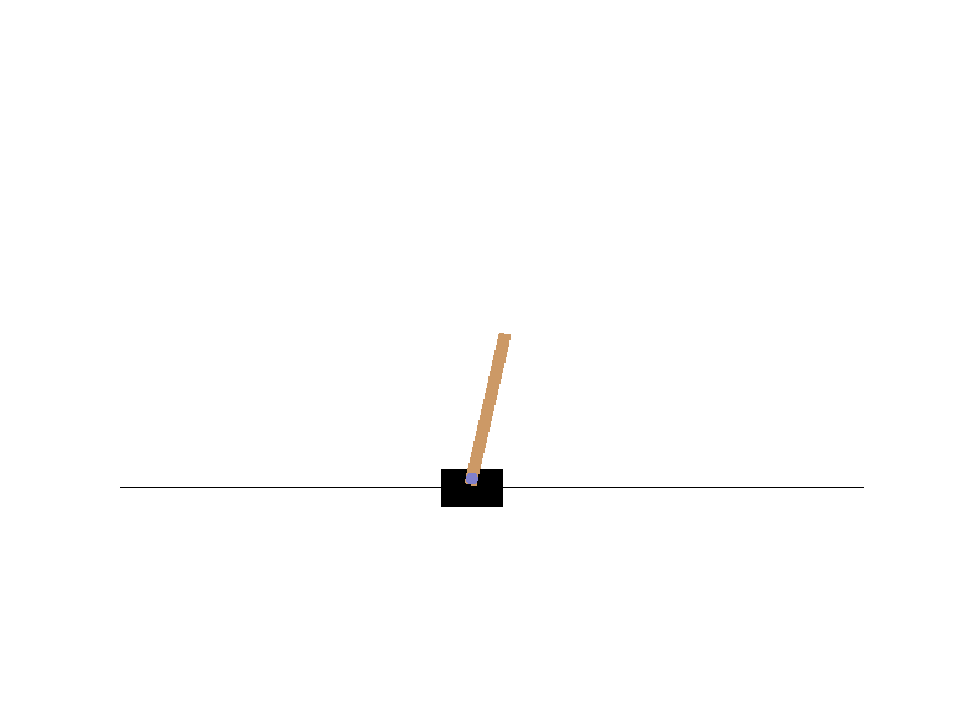

In [29]:
plt.close()  # or else nbagg sometimes plots in the previous cell
img = render_cart_pole(env, obs)
plt.imshow(img)
plt.axis("off")
# save_fig("cart_pole_plot")
plt.show()

In [31]:
img.shape

(400, 600, 3)

请注意，当杆子倾斜太多时，游戏结束，而不是在它实际下降时。 现在让我们重置环境并将购物车推向右边：

In [32]:
obs = env.reset()
while True:
    obs, reward, done, info = env.step(1)
    if done:
        break

<IPython.core.display.Javascript object>


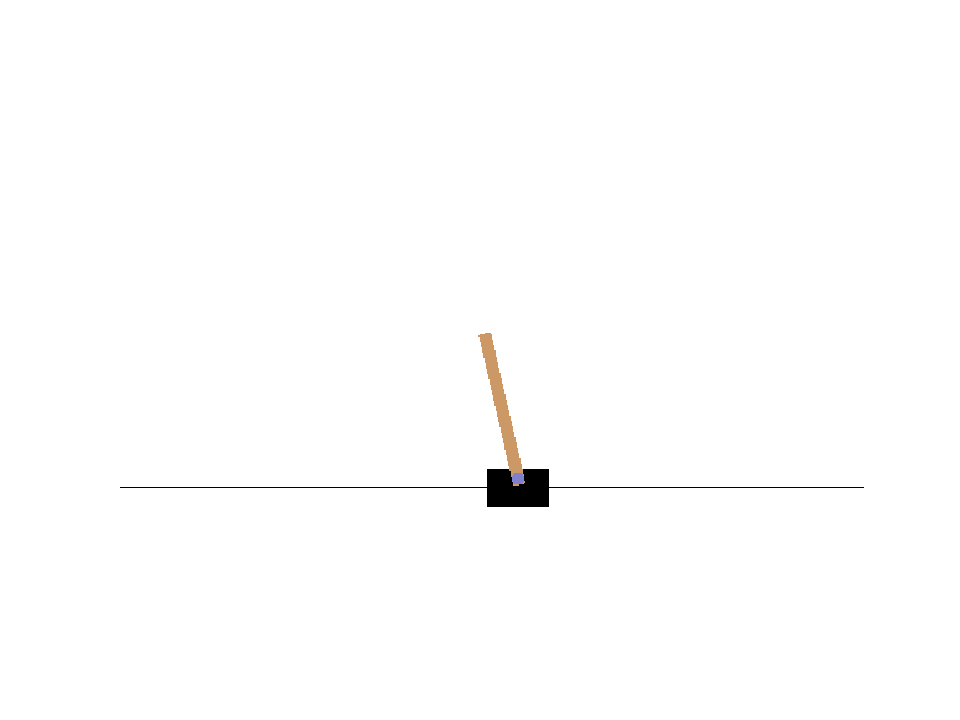

In [33]:
plot_cart_pole(env, obs)

看起来它正在做我们告诉它要做的事情。 现在我们怎样才能使杆保持正常？ 我们需要为此制定政策。 这是代理将用于在每个步骤选择操作的策略。 它可以使用所有过去的操作和观察来决定做什么。

## 简单的硬编码策略

让我们硬编码一个简单的策略：如果杆向左倾斜，则将推车推向左侧，反之亦然。 让我们看看是否有效：

In [34]:
frames = []

n_max_steps = 1000
n_change_steps = 10

obs = env.reset()
for step in range(n_max_steps):
    img = render_cart_pole(env, obs)
    frames.append(img)

    # hard-coded policy
    position, velocity, angle, angular_velocity = obs
    if angle < 0:
        action = 0
    else:
        action = 1

    obs, reward, done, info = env.step(action)
    if done:
        break

<IPython.core.display.Javascript object>


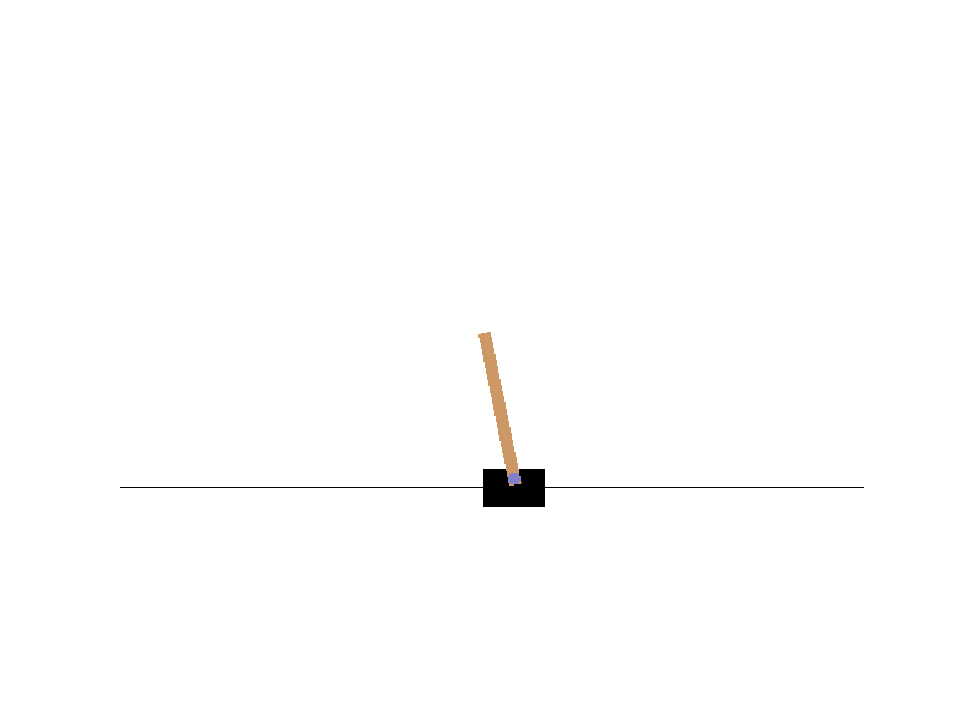

In [36]:
video = plot_animation(frames)
plt.show()

不，系统是不稳定的，只是在几次摆动之后，杆子最终倾斜了：游戏结束。 我们需要比这更聪明！

## 神经网络策略

让我们创建一个神经网络，将观察作为输入，并输出每个观察采取的动作。 为了选择动作，网络将首先估计每个动作的概率，然后根据估计的概率随机选择动作。 在Cart-Pole环境的情况下，只有两个可能的动作（左或右），所以我们只需要一个输出神经元：它将输出动作0的概率p（左），当然还有概率p 行动1（右）将是1  -  p。

注意：我们现在使用tf.layers模块中的dense（）函数，而不是使用tensorflow.contrib.layers模块中的fully_connected（）函数，该函数在编写本章时不存在。 这是优选的，因为contrib中的任何内容都可能更改或删除，恕不另行通知，而tf.layers是官方API的一部分。 正如您将看到的，代码大致相同。

与本章相关的主要差异是：

- 在具有它的所有参数中删除了_fn后缀（例如，activation_fn参数已重命名为activation）。
- weights参数重命名为kernel，
- 默认激活为None而不是tf.nn.relu

In [37]:
import tensorflow as tf

# 1. Specify the network architecture
n_inputs = 4  # == env.observation_space.shape[0]
n_hidden = 4  # it's a simple task, we don't need more than this
n_outputs = 1 # only outputs the probability of accelerating left
initializer = tf.contrib.layers.variance_scaling_initializer()

# 2. Build the neural network
X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden = tf.layers.dense(X, n_hidden, activation=tf.nn.elu,
                         kernel_initializer=initializer)
outputs = tf.layers.dense(hidden, n_outputs, activation=tf.nn.sigmoid,
                          kernel_initializer=initializer)

# 3. Select a random action based on the estimated probabilities
p_left_and_right = tf.concat(axis=1, values=[outputs, 1 - outputs])
action = tf.multinomial(tf.log(p_left_and_right), num_samples=1)

init = tf.global_variables_initializer()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.random.categorical instead.


在这种特殊的环境中，可以安全地忽略过去的行动和观察，因为每次观察都包含环境的完整状态。 如果存在某种隐藏状态，那么您可能需要考虑过去的操作和观察，以便尝试推断环境的隐藏状态。 例如，如果环境仅显示推车的位置而不显示其速度，则不仅要考虑当前观察，还要考虑先前的观察以估计当前速度。 另一个例子是观察结果是否有噪声：您可能希望使用过去几次观察来估计最可能的当前状态。 因此，我们的问题很简单：当前观察是无噪音的，包含环境的完整状态。

您可能想知道为什么我们根据策略网络给出的概率选择随机操作，而不是仅选择概率最高的操作。 这种方法可以让代理在探索新操作和利用已知运行良好的操作之间找到适当的平衡点。 这是一个类比：假设你第一次去餐馆，所有的菜肴看起来都很吸引人，所以你随机选择一个。 如果它证明是好的，你可以增加下次订购它的概率，但你不应该把这个概率提高到100％，否则你永远不会尝试其他菜肴，其中一些甚至可能比你试过的那个要好。

让我们随机初始化这个策略神经网络并用它来玩一个游戏：

In [38]:
n_max_steps = 1000
frames = []

with tf.Session() as sess:
    init.run()
    obs = env.reset()
    for step in range(n_max_steps):
        img = render_cart_pole(env, obs)
        frames.append(img)
        action_val = action.eval(feed_dict={X: obs.reshape(1, n_inputs)})
        obs, reward, done, info = env.step(action_val[0][0])
        if done:
            break

env.close()

现在让我们来看看这个随机初始化的策略网络的执行情况：

<IPython.core.display.Javascript object>


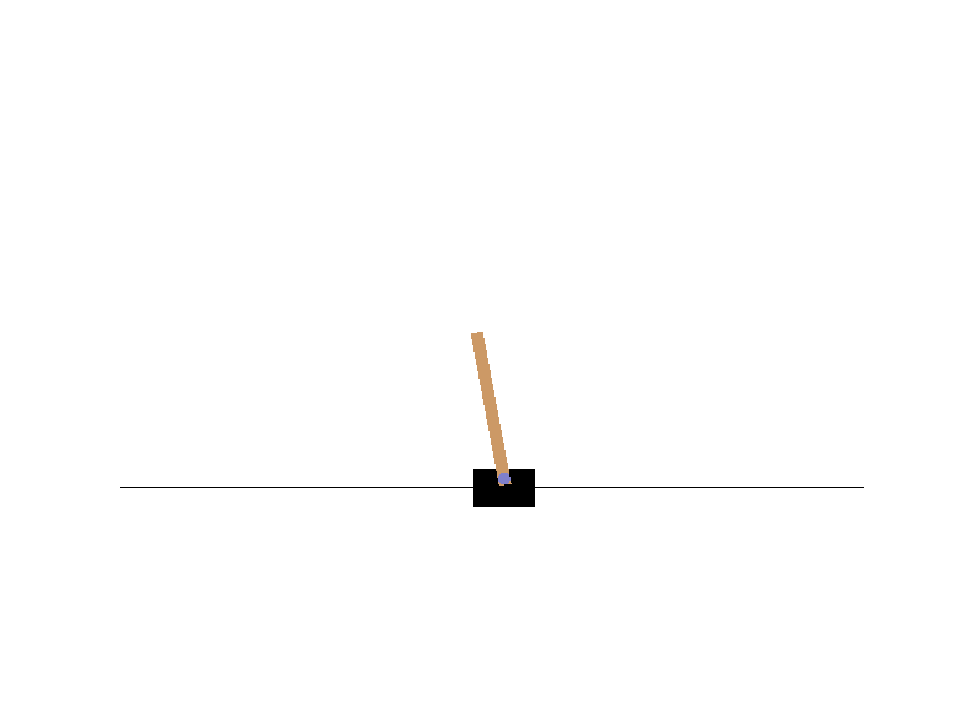

In [39]:
video = plot_animation(frames)
plt.show()

是的......非常糟糕。 神经网络必须学会做得更好。 首先让我们看看它是否能够学习我们之前使用的基本策略：如果杆向左倾斜则向左移动，如果向右倾斜则向右移动。 以下代码定义了相同的神经网络，但我们添加了目标概率y和训练操作（cross_entropy，optimizer和training_op）：

In [40]:
import tensorflow as tf

reset_graph()

n_inputs = 4
n_hidden = 4
n_outputs = 1

learning_rate = 0.01

initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
y = tf.placeholder(tf.float32, shape=[None, n_outputs])

hidden = tf.layers.dense(X, n_hidden, activation=tf.nn.elu, kernel_initializer=initializer)
logits = tf.layers.dense(hidden, n_outputs)
outputs = tf.nn.sigmoid(logits) # probability of action 0 (left)
p_left_and_right = tf.concat(axis=1, values=[outputs, 1 - outputs])
action = tf.multinomial(tf.log(p_left_and_right), num_samples=1)

cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(cross_entropy)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

我们可以在10个不同的环境中并行进行相同的网络游戏，并训练1000次迭代。 我们还在完成后重置环境。

In [41]:
n_environments = 10
n_iterations = 1000

envs = [gym.make("CartPole-v0") for _ in range(n_environments)]
observations = [env.reset() for env in envs]

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        target_probas = np.array([([1.] if obs[2] < 0 else [0.]) for obs in observations]) # if angle<0 we want proba(left)=1., or else proba(left)=0.
        action_val, _ = sess.run([action, training_op], feed_dict={X: np.array(observations), y: target_probas})
        for env_index, env in enumerate(envs):
            obs, reward, done, info = env.step(action_val[env_index][0])
            observations[env_index] = obs if not done else env.reset()
    saver.save(sess, "./my_policy_net_basic.ckpt")

for env in envs:
    env.close()

In [42]:
def render_policy_net(model_path, action, X, n_max_steps = 1000):
    frames = []
    env = gym.make("CartPole-v0")
    obs = env.reset()
    with tf.Session() as sess:
        saver.restore(sess, model_path)
        for step in range(n_max_steps):
            img = render_cart_pole(env, obs)
            frames.append(img)
            action_val = action.eval(feed_dict={X: obs.reshape(1, n_inputs)})
            obs, reward, done, info = env.step(action_val[0][0])
            if done:
                break
    env.close()
    return frames        

INFO:tensorflow:Restoring parameters from ./my_policy_net_basic.ckpt


<IPython.core.display.Javascript object>


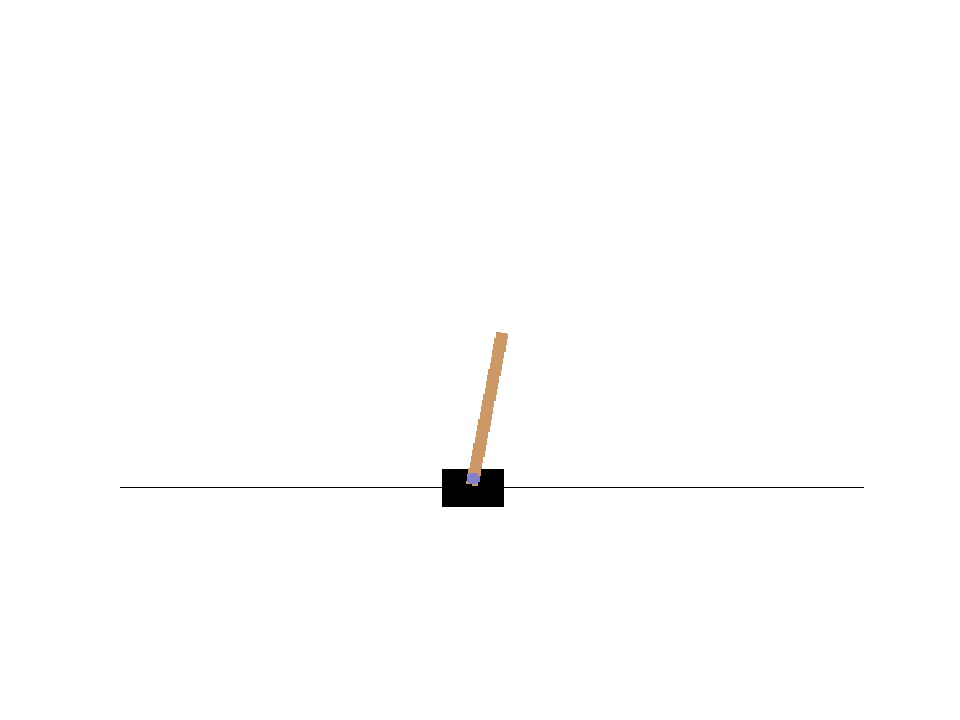

In [44]:
frames = render_policy_net("./my_policy_net_basic.ckpt", action, X)
video = plot_animation(frames)
plt.show()

看起来它正确地学习了政策。 现在让我们看看它是否可以自己学习更好的政策。

## 梯度策略

为了训练这个神经网络，我们需要定义目标概率y。 如果一个动作是好的，我们应该增加它的概率，相反如果它是坏的，我们应该减少它。 但是，我们如何知道行动是好还是坏？ 问题是大多数动作都有延迟效果，所以当你在游戏中赢或输分数时，不清楚哪种动作对这个结果有贡献：它只是最后一个动作吗？ 还是最后10？ 或者只是提前50步？ 这称为信用分配问题。

Policy Gradients算法通过首先玩多个游戏来解决这个问题，然后使得好游戏中的动作稍微更有可能，而糟糕游戏中的动作稍微不那么可能。 首先我们玩，然后我们回去思考我们做了什么。

In [45]:
import tensorflow as tf

reset_graph()

n_inputs = 4
n_hidden = 4
n_outputs = 1

learning_rate = 0.01

initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

hidden = tf.layers.dense(X, n_hidden, activation=tf.nn.elu, kernel_initializer=initializer)
logits = tf.layers.dense(hidden, n_outputs)
outputs = tf.nn.sigmoid(logits)  # probability of action 0 (left)
p_left_and_right = tf.concat(axis=1, values=[outputs, 1 - outputs])
action = tf.multinomial(tf.log(p_left_and_right), num_samples=1)

y = 1. - tf.to_float(action)
cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
optimizer = tf.train.AdamOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(cross_entropy)
gradients = [grad for grad, variable in grads_and_vars]
gradient_placeholders = []
grads_and_vars_feed = []
for grad, variable in grads_and_vars:
    gradient_placeholder = tf.placeholder(tf.float32, shape=grad.get_shape())
    gradient_placeholders.append(gradient_placeholder)
    grads_and_vars_feed.append((gradient_placeholder, variable))
training_op = optimizer.apply_gradients(grads_and_vars_feed)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Instructions for updating:
Use tf.cast instead.


In [46]:
def discount_rewards(rewards, discount_rate):
    discounted_rewards = np.zeros(len(rewards))
    cumulative_rewards = 0
    for step in reversed(range(len(rewards))):
        cumulative_rewards = rewards[step] + cumulative_rewards * discount_rate
        discounted_rewards[step] = cumulative_rewards
    return discounted_rewards

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate) for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean)/reward_std for discounted_rewards in all_discounted_rewards]

In [47]:
discount_rewards([10, 0, -50], discount_rate=0.8)

array([-22., -40., -50.])

In [48]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_rate=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [49]:
env = gym.make("CartPole-v0")

n_games_per_update = 10
n_max_steps = 1000
n_iterations = 250
save_iterations = 10
discount_rate = 0.95

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        print("\rIteration: {}".format(iteration), end="")
        all_rewards = []
        all_gradients = []
        for game in range(n_games_per_update):
            current_rewards = []
            current_gradients = []
            obs = env.reset()
            for step in range(n_max_steps):
                action_val, gradients_val = sess.run([action, gradients], feed_dict={X: obs.reshape(1, n_inputs)})
                obs, reward, done, info = env.step(action_val[0][0])
                current_rewards.append(reward)
                current_gradients.append(gradients_val)
                if done:
                    break
            all_rewards.append(current_rewards)
            all_gradients.append(current_gradients)

        all_rewards = discount_and_normalize_rewards(all_rewards, discount_rate=discount_rate)
        feed_dict = {}
        for var_index, gradient_placeholder in enumerate(gradient_placeholders):
            mean_gradients = np.mean([reward * all_gradients[game_index][step][var_index]
                                      for game_index, rewards in enumerate(all_rewards)
                                          for step, reward in enumerate(rewards)], axis=0)
            feed_dict[gradient_placeholder] = mean_gradients
        sess.run(training_op, feed_dict=feed_dict)
        if iteration % save_iterations == 0:
            saver.save(sess, "./my_policy_net_pg.ckpt")

Iteration: 249

INFO:tensorflow:Restoring parameters from ./my_policy_net_pg.ckpt


<IPython.core.display.Javascript object>


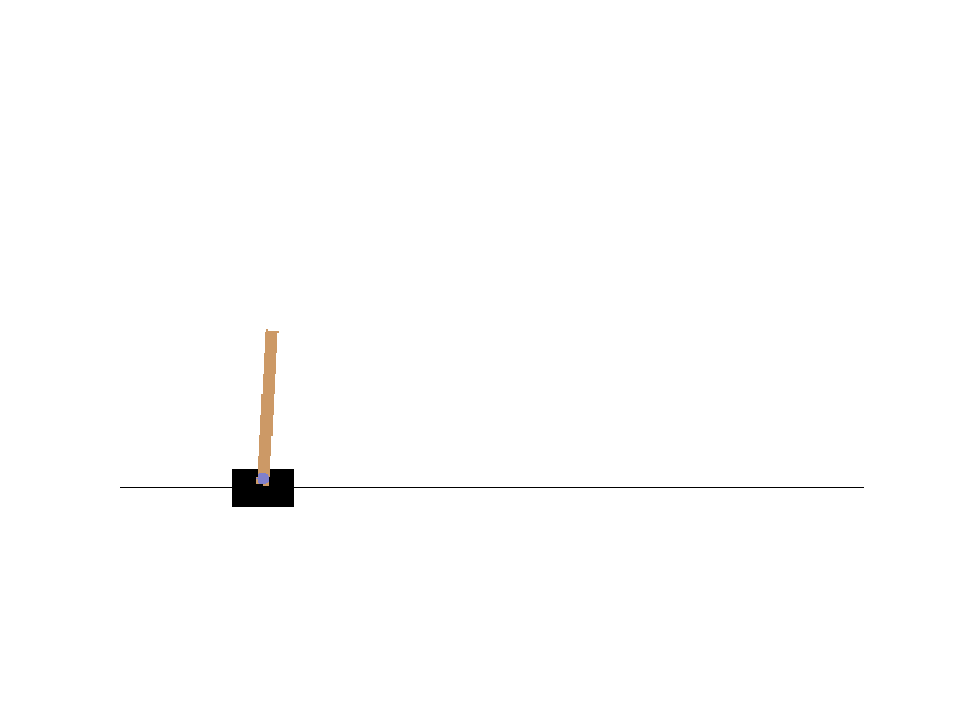

In [53]:
frames = render_policy_net("./my_policy_net_pg.ckpt", action, X, n_max_steps=99999999)
video = plot_animation(frames)
plt.show()

## 马尔科夫链

In [54]:
transition_probabilities = [
        [0.7, 0.2, 0.0, 0.1],  # from s0 to s0, s1, s2, s3
        [0.0, 0.0, 0.9, 0.1],  # from s1 to ...
        [0.0, 1.0, 0.0, 0.0],  # from s2 to ...
        [0.0, 0.0, 0.0, 1.0],  # from s3 to ...
    ]

n_max_steps = 50

def print_sequence(start_state=0):
    current_state = start_state
    print("States:", end=" ")
    for step in range(n_max_steps):
        print(current_state, end=" ")
        if current_state == 3:
            break
        current_state = np.random.choice(range(4), p=transition_probabilities[current_state])
    else:
        print("...", end="")
    print()

for _ in range(10):
    print_sequence()

States: 0 0 3 
States: 0 1 2 1 2 1 2 1 2 1 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
States: 0 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
States: 0 1 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 ...
States: 0 0 3 
States: 0 0 0 1 2 1 2 1 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 


## 马尔科夫决策过程

In [55]:
transition_probabilities = [
        [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]], # in s0, if action a0 then proba 0.7 to state s0 and 0.3 to state s1, etc.
        [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
        [None, [0.8, 0.1, 0.1], None],
    ]

rewards = [
        [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
        [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
        [[0, 0, 0], [+40, 0, 0], [0, 0, 0]],
    ]

possible_actions = [[0, 1, 2], [0, 2], [1]]

def policy_fire(state):
    return [0, 2, 1][state]

def policy_random(state):
    return np.random.choice(possible_actions[state])

def policy_safe(state):
    return [0, 0, 1][state]

class MDPEnvironment(object):
    def __init__(self, start_state=0):
        self.start_state=start_state
        self.reset()
    def reset(self):
        self.total_rewards = 0
        self.state = self.start_state
    def step(self, action):
        next_state = np.random.choice(range(3), p=transition_probabilities[self.state][action])
        reward = rewards[self.state][action][next_state]
        self.state = next_state
        self.total_rewards += reward
        return self.state, reward

def run_episode(policy, n_steps, start_state=0, display=True):
    env = MDPEnvironment()
    if display:
        print("States (+rewards):", end=" ")
    for step in range(n_steps):
        if display:
            if step == 10:
                print("...", end=" ")
            elif step < 10:
                print(env.state, end=" ")
        action = policy(env.state)
        state, reward = env.step(action)
        if display and step < 10:
            if reward:
                print("({})".format(reward), end=" ")
    if display:
        print("Total rewards =", env.total_rewards)
    return env.total_rewards

for policy in (policy_fire, policy_random, policy_safe):
    all_totals = []
    print(policy.__name__)
    for episode in range(1000):
        all_totals.append(run_episode(policy, n_steps=100, display=(episode<5)))
    print("Summary: mean={:.1f}, std={:1f}, min={}, max={}".format(np.mean(all_totals), np.std(all_totals), np.min(all_totals), np.max(all_totals)))
    print()

policy_fire
States (+rewards): 0 (10) 0 (10) 0 1 (-50) 2 2 2 (40) 0 (10) 0 (10) 0 (10) ... Total rewards = 210
States (+rewards): 0 1 (-50) 2 (40) 0 (10) 0 (10) 0 1 (-50) 2 2 (40) 0 (10) ... Total rewards = 70
States (+rewards): 0 (10) 0 1 (-50) 2 (40) 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) ... Total rewards = 70
States (+rewards): 0 1 (-50) 2 1 (-50) 2 (40) 0 (10) 0 1 (-50) 2 (40) 0 ... Total rewards = -10
States (+rewards): 0 1 (-50) 2 (40) 0 (10) 0 (10) 0 1 (-50) 2 (40) 0 (10) 0 (10) ... Total rewards = 290
Summary: mean=121.1, std=129.333766, min=-330, max=470

policy_random
States (+rewards): 0 1 (-50) 2 1 (-50) 2 (40) 0 1 (-50) 2 2 (40) 0 ... Total rewards = -60
States (+rewards): 0 (10) 0 0 0 0 0 (10) 0 0 0 (10) 0 ... Total rewards = -30
States (+rewards): 0 1 1 (-50) 2 (40) 0 0 1 1 1 1 ... Total rewards = 10
States (+rewards): 0 (10) 0 (10) 0 0 0 0 1 (-50) 2 (40) 0 0 ... Total rewards = 0
States (+rewards): 0 0 (10) 0 1 (-50) 2 (40) 0 0 0 0 (10) 0 (10) ... Total rewards = 40

## Q-Learning

Q-Learning通过观察代理播放（例如，随机）并逐渐改进其Q值的估计来工作。 一旦它具有准确的Q值估计（或足够接近），则最优策略在于选择具有最高Q值的动作（即，贪婪策略）。

In [56]:
n_states = 3
n_actions = 3
n_steps = 20000
alpha = 0.01
gamma = 0.99
exploration_policy = policy_random
q_values = np.full((n_states, n_actions), -np.inf)
for state, actions in enumerate(possible_actions):
    q_values[state][actions]=0

env = MDPEnvironment()
for step in range(n_steps):
    action = exploration_policy(env.state)
    state = env.state
    next_state, reward = env.step(action)
    next_value = np.max(q_values[next_state]) # greedy policy
    q_values[state, action] = (1-alpha)*q_values[state, action] + alpha*(reward + gamma * next_value)

In [57]:
def optimal_policy(state):
    return np.argmax(q_values[state])

In [58]:
q_values

array([[39.13508139, 38.88079412, 35.23025716],
       [18.9117071 ,        -inf, 20.54567816],
       [       -inf, 72.53192111,        -inf]])

In [59]:
all_totals = []
for episode in range(1000):
    all_totals.append(run_episode(optimal_policy, n_steps=100, display=(episode<5)))
print("Summary: mean={:.1f}, std={:1f}, min={}, max={}".format(np.mean(all_totals), np.std(all_totals), np.min(all_totals), np.max(all_totals)))
print()

States (+rewards): 0 (10) 0 (10) 0 1 (-50) 2 (40) 0 (10) 0 1 (-50) 2 (40) 0 (10) ... Total rewards = 230
States (+rewards): 0 (10) 0 (10) 0 (10) 0 1 (-50) 2 2 1 (-50) 2 (40) 0 (10) ... Total rewards = 90
States (+rewards): 0 1 (-50) 2 (40) 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) ... Total rewards = 170
States (+rewards): 0 1 (-50) 2 (40) 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) ... Total rewards = 220
States (+rewards): 0 1 (-50) 2 (40) 0 (10) 0 1 (-50) 2 (40) 0 (10) 0 (10) 0 (10) ... Total rewards = -50
Summary: mean=125.6, std=127.363464, min=-290, max=500



## 学习使用DQN算法播放MsPacman

警告：不幸的是，本书的第一个版本在本节中包含两个重要错误。

1. 演员DQN和评论家DQN应分别被命名为在线DQN和目标DQN。 Actor-critic算法是一类独特的算法。

2. 在线DQN是定期学习并复制到目标DQN的DQN。 目标DQN的唯一作用是估计每个可能行动的下一个状态的Q值。 这需要计算用于训练在线DQN的目标Q值，如下面的等式所示：

$y(s,a) = \text{r} + \gamma . \underset{a'}{\max} \, Q_\text{target}(s', a')$

## 创建MsPacman环境

In [60]:
env = gym.make("MsPacman-v0")
obs = env.reset()
obs.shape

(210, 160, 3)

In [61]:
env.action_space

Discrete(9)

## 预处理

预处理图像是可选的，但大大加快了培训速度。

In [62]:
mspacman_color = 210 + 164 + 74

def preprocess_observation(obs):
    img = obs[1:176:2, ::2] # crop and downsize
    img = img.sum(axis=2) # to greyscale
    img[img==mspacman_color] = 0 # Improve contrast
    img = (img // 3 - 128).astype(np.int8) # normalize from -128 to 127
    return img.reshape(88, 80, 1)

img = preprocess_observation(obs)

注意：preprocess_observation（）函数与书中的函数略有不同：它不是将像素表示为从-1.0到1.0的64位浮点数，而是将它们表示为有符号字节（从-128到127）。 好处是重放内存将占用大约8倍的RAM（大约6.5 GB而不是52 GB）。 精度降低对训练没有明显影响。

<IPython.core.display.Javascript object>


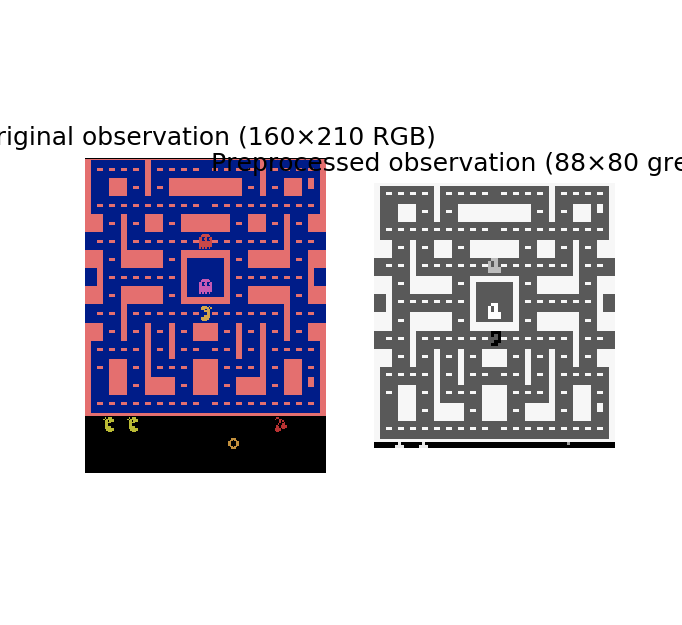

In [64]:
plt.figure(figsize=(11, 7))
plt.subplot(121)
plt.title("Original observation (160×210 RGB)")
plt.imshow(obs)
plt.axis("off")
plt.subplot(122)
plt.title("Preprocessed observation (88×80 greyscale)")
plt.imshow(img.reshape(88, 80), interpolation="nearest", cmap="gray")
plt.axis("off")
plt.show()

## 构建DQN

注意：我们现在使用的是tf.layers.conv2d（），而不是使用tf.contrib.layers.convolution2d（）或tf.contrib.layers.conv2d（）（如本书的第一个版本）。 在撰写本章时存在。 这是优选的，因为contrib中的任何内容都可能更改或删除，恕不另行通知，而tf.layers是官方API的一部分。 正如您将看到的，代码大致相同，只是参数名称略有改变：

- num_outputs参数已重命名为filters，
- stride参数重命名为strides，
- _fn后缀已从具有它的参数名称中删除（例如，activation_fn已重命名为activation），
- weights_initializer参数已重命名为kernel_initializer，
- weights变量重命名为kernel，biases变量从“biases”重命名为“bias”，
- 并且默认activation现在为None而不是tf.nn.relu。

In [65]:
reset_graph()

input_height = 88
input_width = 80
input_channels = 1
conv_n_maps = [32, 64, 64]
conv_kernel_sizes = [(8,8), (4,4), (3,3)]
conv_strides = [4, 2, 1]
conv_paddings = ["SAME"] * 3 
conv_activation = [tf.nn.relu] * 3
n_hidden_in = 64 * 11 * 10  # conv3 has 64 maps of 11x10 each
n_hidden = 512
hidden_activation = tf.nn.relu
n_outputs = env.action_space.n  # 9 discrete actions are available
initializer = tf.contrib.layers.variance_scaling_initializer()

def q_network(X_state, name):
    prev_layer = X_state / 128.0 # scale pixel intensities to the [-1.0, 1.0] range.
    with tf.variable_scope(name) as scope:
        for n_maps, kernel_size, strides, padding, activation in zip(
                conv_n_maps, conv_kernel_sizes, conv_strides,
                conv_paddings, conv_activation):
            prev_layer = tf.layers.conv2d(
                prev_layer, filters=n_maps, kernel_size=kernel_size,
                strides=strides, padding=padding, activation=activation,
                kernel_initializer=initializer)
        last_conv_layer_flat = tf.reshape(prev_layer, shape=[-1, n_hidden_in])
        hidden = tf.layers.dense(last_conv_layer_flat, n_hidden,
                                 activation=hidden_activation,
                                 kernel_initializer=initializer)
        outputs = tf.layers.dense(hidden, n_outputs,
                                  kernel_initializer=initializer)
    trainable_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                       scope=scope.name)
    trainable_vars_by_name = {var.name[len(scope.name):]: var
                              for var in trainable_vars}
    return outputs, trainable_vars_by_name

In [66]:
X_state = tf.placeholder(tf.float32, shape=[None, input_height, input_width,
                                            input_channels])
online_q_values, online_vars = q_network(X_state, name="q_networks/online")
target_q_values, target_vars = q_network(X_state, name="q_networks/target")

copy_ops = [target_var.assign(online_vars[var_name])
            for var_name, target_var in target_vars.items()]
copy_online_to_target = tf.group(*copy_ops)

Instructions for updating:
Use keras.layers.conv2d instead.


In [67]:
online_vars

{'/conv2d/bias:0': <tf.Variable 'q_networks/online/conv2d/bias:0' shape=(32,) dtype=float32_ref>,
 '/conv2d/kernel:0': <tf.Variable 'q_networks/online/conv2d/kernel:0' shape=(8, 8, 1, 32) dtype=float32_ref>,
 '/conv2d_1/bias:0': <tf.Variable 'q_networks/online/conv2d_1/bias:0' shape=(64,) dtype=float32_ref>,
 '/conv2d_1/kernel:0': <tf.Variable 'q_networks/online/conv2d_1/kernel:0' shape=(4, 4, 32, 64) dtype=float32_ref>,
 '/conv2d_2/bias:0': <tf.Variable 'q_networks/online/conv2d_2/bias:0' shape=(64,) dtype=float32_ref>,
 '/conv2d_2/kernel:0': <tf.Variable 'q_networks/online/conv2d_2/kernel:0' shape=(3, 3, 64, 64) dtype=float32_ref>,
 '/dense/bias:0': <tf.Variable 'q_networks/online/dense/bias:0' shape=(512,) dtype=float32_ref>,
 '/dense/kernel:0': <tf.Variable 'q_networks/online/dense/kernel:0' shape=(7040, 512) dtype=float32_ref>,
 '/dense_1/bias:0': <tf.Variable 'q_networks/online/dense_1/bias:0' shape=(9,) dtype=float32_ref>,
 '/dense_1/kernel:0': <tf.Variable 'q_networks/online/de

In [68]:
learning_rate = 0.001
momentum = 0.95

with tf.variable_scope("train"):
    X_action = tf.placeholder(tf.int32, shape=[None])
    y = tf.placeholder(tf.float32, shape=[None, 1])
    q_value = tf.reduce_sum(online_q_values * tf.one_hot(X_action, n_outputs),
                            axis=1, keep_dims=True)
    error = tf.abs(y - q_value)
    clipped_error = tf.clip_by_value(error, 0.0, 1.0)
    linear_error = 2 * (error - clipped_error)
    loss = tf.reduce_mean(tf.square(clipped_error) + linear_error)

    global_step = tf.Variable(0, trainable=False, name='global_step')
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
    training_op = optimizer.minimize(loss, global_step=global_step)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.cast instead.


注意：在本书的第一个版本中，损失函数只是目标Q值（y）和估计Q值（q_value）之间的平方误差。 但是，由于经验非常嘈杂，最好只对小错误（低于1.0）使用二次损失，对较大错误使用线性损失（绝对误差的两倍），这就是上面的代码计算的结果。 这样，大错误不会将模型参数推到尽可能多的位置。 请注意，我们还调整了一些超参数（使用较小的学习速率，并使用Nesterov Accelerated Gradients而不是Adam优化，因为根据本文，自适应梯度算法有时可能很糟糕）。 我们还调整了下面的一些其他超参数（更大的重放内存，ε-greedy策略更长的衰减，更大的折扣率，更少的在线DQN到目标DQN的拷贝等）。

In [70]:
from collections import deque

replay_memory_size = 500000
replay_memory = deque([], maxlen=replay_memory_size)

def sample_memories(batch_size):
    indices = np.random.permutation(len(replay_memory))[:batch_size]
    cols = [[], [], [], [], []] # state, action, reward, next_state, continue
    for idx in indices:
        memory = replay_memory[idx]
        for col, value in zip(cols, memory):
            col.append(value)
    cols = [np.array(col) for col in cols]
    return cols[0], cols[1], cols[2].reshape(-1, 1), cols[3], cols[4].reshape(-1, 1)

In [71]:
eps_min = 0.1
eps_max = 1.0
eps_decay_steps = 2000000

def epsilon_greedy(q_values, step):
    epsilon = max(eps_min, eps_max - (eps_max-eps_min) * step/eps_decay_steps)
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs) # random action
    else:
        return np.argmax(q_values) # optimal action

In [87]:
n_steps = 4000000  # total number of training steps
training_start = 10000  # start training after 10,000 game iterations
training_interval = 4  # run a training step every 4 game iterations
save_steps = 1000  # save the model every 1,000 training steps
copy_steps = 10000  # copy online DQN to target DQN every 10,000 training steps
discount_rate = 0.99
skip_start = 90  # Skip the start of every game (it's just waiting time).
batch_size = 50
iteration = 0  # game iterations
checkpoint_path = "./my_dqn.ckpt"
done = True # env needs to be reset

In [88]:
loss_val = np.infty
game_length = 0
total_max_q = 0
mean_max_q = 0.0

In [89]:
with tf.Session() as sess:
    if os.path.isfile(checkpoint_path + ".index"):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()
        copy_online_to_target.run()
    while True:
        step = global_step.eval()
        if step >= n_steps:
            break
        iteration += 1
        print("\rIteration {}\tTraining step {}/{} ({:.1f})%\tLoss {:5f}\tMean Max-Q {:5f}   ".format(
            iteration, step, n_steps, step * 100 / n_steps, loss_val, mean_max_q), end="")
        if done: # game over, start again
            obs = env.reset()
            for skip in range(skip_start): # skip the start of each game
                obs, reward, done, info = env.step(0)
            state = preprocess_observation(obs)

        # Online DQN evaluates what to do
        q_values = online_q_values.eval(feed_dict={X_state: [state]})
        action = epsilon_greedy(q_values, step)

        # Online DQN plays
        obs, reward, done, info = env.step(action)
        next_state = preprocess_observation(obs)

        # Let's memorize what happened
        replay_memory.append((state, action, reward, next_state, 1.0 - done))
        state = next_state

        # Compute statistics for tracking progress (not shown in the book)
        total_max_q += q_values.max()
        game_length += 1
        if done:
            mean_max_q = total_max_q / game_length
            total_max_q = 0.0
            game_length = 0

        if iteration < training_start or iteration % training_interval != 0:
            continue # only train after warmup period and at regular intervals
        
        # Sample memories and use the target DQN to produce the target Q-Value
        X_state_val, X_action_val, rewards, X_next_state_val, continues = (
            sample_memories(batch_size))
        next_q_values = target_q_values.eval(
            feed_dict={X_state: X_next_state_val})
        max_next_q_values = np.max(next_q_values, axis=1, keepdims=True)
        y_val = rewards + continues * discount_rate * max_next_q_values

        # Train the online DQN
        _, loss_val = sess.run([training_op, loss], feed_dict={
            X_state: X_state_val, X_action: X_action_val, y: y_val})

        # Regularly copy the online DQN to the target DQN
        if step % copy_steps == 0:
            copy_online_to_target.run()

        # And save regularly
        if step % save_steps == 0:
            saver.save(sess, checkpoint_path)

INFO:tensorflow:Restoring parameters from ./my_dqn.ckpt
Iteration 1	Training step 15001/4000000 (0.4)%	Loss   inf	Mean Max-Q 0.000000   

ValueError: Cannot feed value of shape (1, 80, 80) for Tensor 'Placeholder:0', which has shape '(?, 88, 80, 1)'

您可以随时中断上面的单元格，使用下面的单元格测试您的代理程序。 然后，您可以再次运行上面的单元格，它将加载最后保存的参数并恢复训练。

In [77]:
frames = []
n_max_steps = 10000

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)

    obs = env.reset()
    for step in range(n_max_steps):
        state = preprocess_observation(obs)

        # Online DQN evaluates what to do
        q_values = online_q_values.eval(feed_dict={X_state: [state]})
        action = np.argmax(q_values)

        # Online DQN plays
        obs, reward, done, info = env.step(action)

        img = env.render(mode="rgb_array")
        frames.append(img)

        if done:
            break

INFO:tensorflow:Restoring parameters from ./my_dqn.ckpt


<IPython.core.display.Javascript object>


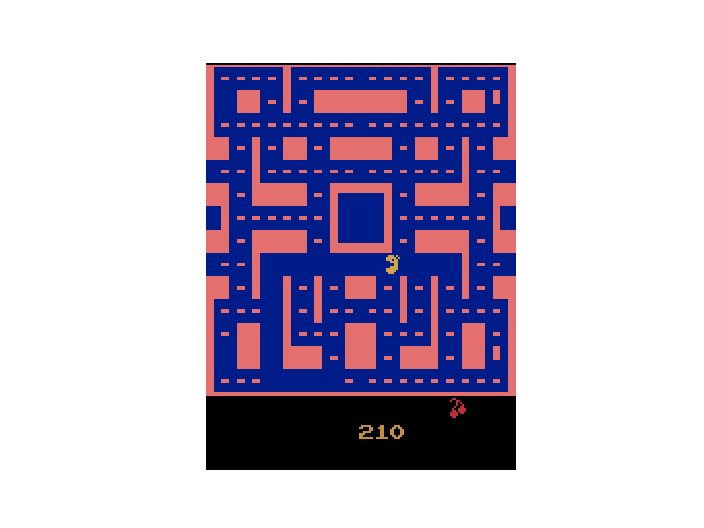

In [78]:
plot_animation(frames)

## 额外材料

这是一个预处理功能，您可以使用它来训练Breakout-v0 Atari游戏的DQN：

In [79]:
def preprocess_observation(obs):
    img = obs[34:194:2, ::2] # crop and downsize
    return np.mean(img, axis=2).reshape(80, 80) / 255.0

In [80]:
env = gym.make("Breakout-v0")
obs = env.reset()
for step in range(10):
    obs, _, _, _ = env.step(1)

img = preprocess_observation(obs)

<IPython.core.display.Javascript object>


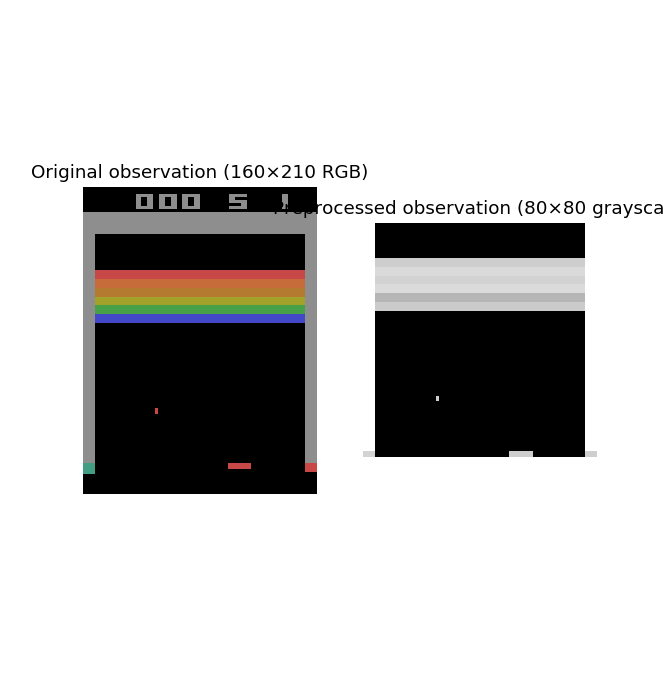

In [81]:
plt.figure(figsize=(11, 7))
plt.subplot(121)
plt.title("Original observation (160×210 RGB)")
plt.imshow(obs)
plt.axis("off")
plt.subplot(122)
plt.title("Preprocessed observation (80×80 grayscale)")
plt.imshow(img, interpolation="nearest", cmap="gray")
plt.axis("off")
plt.show()

正如您所看到的，单个图像并不能为您提供球的方向和速度，这是玩这个游戏的关键信息。 出于这个原因，最好实际组合几个连续的观察来创建环境的状态表示。 一种方法是创建一个多通道图像，每个最近观察一个通道。 另一种方法是使用np.max（）将所有最近的观察结果合并为单通道图像。 在这种情况下，我们需要调暗旧图像，以便DQN可以区分过去和现在。

In [82]:
def combine_observations_multichannel(preprocessed_observations):
    return np.array(preprocessed_observations).transpose([1, 2, 0])

def combine_observations_singlechannel(preprocessed_observations, dim_factor=0.5):
    dimmed_observations = [obs * dim_factor**index
                           for index, obs in enumerate(reversed(preprocessed_observations))]
    return np.max(np.array(dimmed_observations), axis=0)

n_observations_per_state = 3
preprocessed_observations = deque([], maxlen=n_observations_per_state)

obs = env.reset()
for step in range(10):
    obs, _, _, _ = env.step(1)
    preprocessed_observations.append(preprocess_observation(obs))

<IPython.core.display.Javascript object>


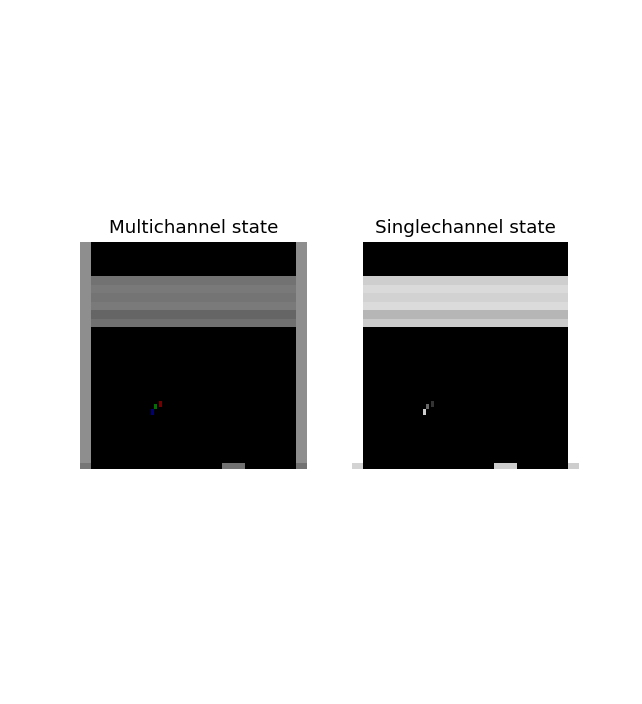

In [83]:
img1 = combine_observations_multichannel(preprocessed_observations)
img2 = combine_observations_singlechannel(preprocessed_observations)

plt.figure(figsize=(11, 7))
plt.subplot(121)
plt.title("Multichannel state")
plt.imshow(img1, interpolation="nearest")
plt.axis("off")
plt.subplot(122)
plt.title("Singlechannel state")
plt.imshow(img2, interpolation="nearest", cmap="gray")
plt.axis("off")
plt.show()